# Heart rate prediction Neural Network

In [434]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## Parameters

In [435]:
# !! Change neural network layers further down in model definition

SHUFFLE_TRAIN_DATA = True
BATCH_SIZE = 16

MAX_EPOCHS = 250
MIN_EPOCHS = 20
SIMILAR_LOSS_EPOCHS_BEFORE_STOPPING = 10

LEARNING_RATE = 0.001
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# DON'T CHANGE BETWEEN TESTING - train split = 1 - val split - test split
VAL_SPLIT = 0.05
TEST_SPLIT = 0.05

## Prepare model Archiving

In [436]:
# Prepare data folder for archiving
import os

# Ensure that we have a folder for the model archives
MODELS_FOLDER = "model_archive"
os.makedirs(MODELS_FOLDER, exist_ok=True)

# Find current model iteration by looking at the folders in the current directory
CURRENT_MODEL_ITERATION = len([name for name in os.listdir(os.path.join('.', 'model_archive'))])

# Create folder for current model iteration
ITERATION_FOLDER = os.path.join(MODELS_FOLDER, "model_{}".format(CURRENT_MODEL_ITERATION))
os.mkdir(ITERATION_FOLDER)

## Import and prepare data

In [437]:
# Import data
df = pd.read_csv('../data/combined_dataframe.csv')

# Drop irrelevant columns
df = df.drop(['START_TIME', 'END_TIME'], axis=1)

# Convert bools to ints in every column that has bools
bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)

df.head(5)

,TAG_LECTURE,TAG_MEETING,TAG_WORKOUT,TAG_VOLLEYBAL,TAG_PARTY,TAG_TUTOR,TAG_HAIRCUT,TAG_SELFSTUDY,TAG_PROMOCIE,TAG_COOKING,...,TAG_CALLING,TAG_HIGHSCHOOLFRIENDS,DURATION,DAY_OF_WEEK,HOUR_OF_DAY,EVENTS_PER_DAY,HRT_AVG,HRT_MED,HRT_10,HRT_90
0,1,0,0,0,0,0,0,0,0,0,...,0,0,240,1,8,4,83.152174,80.0,70.9,99.2
1,1,1,0,0,0,0,0,0,0,0,...,0,0,240,2,8,6,91.588496,90.0,76.0,113.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,120,2,13,6,85.271930,83.0,73.3,99.7
3,1,1,0,0,0,0,0,0,0,0,...,0,0,240,3,13,5,80.308696,78.0,70.0,95.0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,120,4,8,5,81.615385,79.0,71.3,95.4


In [438]:
np.random.seed(42)

target_headers = ["HRT_AVG", "HRT_MED", "HRT_10", "HRT_90"]
X = df.drop(target_headers, axis=1)
y = df[target_headers]

# Normalize target data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# y = scaler.fit_transform(y)

# Create train test split as tensors
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(TEST_SPLIT))
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=(TEST_SPLIT/(TEST_SPLIT + VAL_SPLIT)))

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)


## NN model

In [439]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Reset Keras Session for resetting indeces of layers
from keras import backend as K
K.clear_session()

model = None
model = Sequential([
    Dense(units=24, input_shape=[len(X.columns)], activation='relu'),
    Dense(units=4, activation='linear')
])


# Compile
model.compile(optimizer=optimiser, loss='mse', metrics=['mae'])

### Save model plot visualization

In [440]:
MODEL_PLOT_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_plot.png")
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR", expand_nested=True, to_file=MODEL_PLOT_FILE_PATH)

# Save model_summary.txt
MODEL_SUMMARY_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_summary.txt")
with open(MODEL_SUMMARY_FILE_PATH, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

### Prepare model callbacks

Creates callbacks for showing the training process, checkpoints and early stopping.

In [441]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Mean error callback 
train_mse = []
val_mse = []
class MeanErrorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_mse.append(logs['loss'])
        val_mse.append(logs['val_loss'])
        
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=SIMILAR_LOSS_EPOCHS_BEFORE_STOPPING,
    mode='min',
    restore_best_weights=False,
    start_from_epoch=MIN_EPOCHS
)

# Checkpoint
CHECKPOINT_FOLDER = os.path.join(ITERATION_FOLDER, "checkpoints")
CHECKPOINT_FILE_PATH = os.path.join(CHECKPOINT_FOLDER, "checkpoint")
os.mkdir(CHECKPOINT_FOLDER)
model_checkpoint_callback = ModelCheckpoint(
    filepath=CHECKPOINT_FILE_PATH,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

### Train model

In [442]:
# Training
mean_error_callback = MeanErrorCallback()
model.fit(X_train, 
          y_train, 
          epochs=MAX_EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=SHUFFLE_TRAIN_DATA, 
          callbacks=[mean_error_callback, early_stopping, model_checkpoint_callback], 
          validation_data=(X_val, y_val))

# Save final model weights to file
MODEL_WEIGHTS_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_weights.h5")
model.save_weights(MODEL_WEIGHTS_FILE_PATH)

# After training, load the best weights found
model.load_weights(CHECKPOINT_FILE_PATH)

# Save optimal model weights to file
MODEL_OPTIMAL_WEIGHTS_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_optimal_weights.h5")
model.save_weights(MODEL_OPTIMAL_WEIGHTS_FILE_PATH)


Epoch 1/250


46/46 [==============================] - 1s 8ms/step - loss: 7678.8950 - mae: 81.7934 - val_loss: 6462.3770 - val_mae: 74.5014
Epoch 2/250
46/46 [==============================] - 0s 6ms/step - loss: 5757.0493 - mae: 70.1515 - val_loss: 4710.4868 - val_mae: 62.4312
Epoch 3/250
46/46 [==============================] - 0s 6ms/step - loss: 4123.8472 - mae: 57.9443 - val_loss: 3244.7561 - val_mae: 49.5065
Epoch 4/250
46/46 [==============================] - 0s 5ms/step - loss: 2854.7395 - mae: 46.6856 - val_loss: 2253.0420 - val_mae: 40.5553
Epoch 5/250
46/46 [==============================] - 0s 6ms/step - loss: 1970.8136 - mae: 37.6066 - val_loss: 1554.9744 - val_mae: 31.9074
Epoch 6/250
46/46 [==============================] - 0s 6ms/step - loss: 1438.1919 - mae: 31.0814 - val_loss: 1300.7373 - val_mae: 27.7784
Epoch 7/250
46/46 [==============================] - 0s 6ms/step - loss: 1253.4194 - mae: 28.2511 - val_loss: 1191.7008 - val_mae: 26.2819
Epoch 8/250
46/46 [====================

### Save model weights visualization

In [443]:
# Visualise weights of the model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

def get_layer_output_function(model, layer_name):
    layer = model.get_layer(layer_name)
    return K.function([model.input], [layer.output])

def get_layer_output(model, layer_name, X):
    func = get_layer_output_function(model, layer_name)
    return func([X])[0]

def plot_layer_weights(model, layer_name, X, figsize=(20, 20)):
    weights = get_layer_output(model, layer_name, X)
    plt.figure(figsize=figsize)
    plt.imshow(weights, cmap='viridis')
    plt.colorbar()

# Plot layer weights
LAYER_WEIGHTS_FOLDER = os.path.join(ITERATION_FOLDER, "layer_weights")
os.makedirs(LAYER_WEIGHTS_FOLDER, exist_ok=True)

for layer in model.layers:
    plot_layer_weights(model, layer.name, X_train)
    plt.savefig(os.path.join(LAYER_WEIGHTS_FOLDER, "{}.png".format(str(layer.units) + layer.name)))
    plt.close()


### Evaluate model

In [444]:
# Make predictions
VAL_EVALUATION = model.evaluate(X_val, y_val)

print("EVALUATION:", VAL_EVALUATION)

print("MSE:", VAL_EVALUATION[0])
print("RMSE:", np.sqrt(VAL_EVALUATION[0]))
print("MAE:", VAL_EVALUATION[1])

RUN_EPOCHS = len(train_mse)

1/1 [==============================] - 0s 27ms/step - loss: 72.6343 - mae: 7.4384
EVALUATION: [72.63432312011719, 7.4384026527404785]
MSE: 72.63432312011719
RMSE: 8.522577258090253
MAE: 7.4384026527404785


In [445]:
# Show prediction of the first x items in val set
amount = 10

inspection_features = X_val[:amount]
inspection_targets = y_val[:amount]
inspection_predictions = model.predict(inspection_features)

# Print feature headers and target headers first
print("Features: {}".format(X.columns))
print("Targets: {}".format(target_headers))
print("")

for i in range(amount):
    print("Features: {}".format(inspection_features[i]))
    
    for j in range(len(inspection_targets[i])):
        delta = inspection_targets[i][j] - inspection_predictions[i][j]
        print("{} - T: {} - P: {} - Delta: {}".format(target_headers[j], inspection_targets[i][j], inspection_predictions[i][j], delta))
    
    print("")

1/1 [==============================] - 0s 64ms/step
Features: Index(['TAG_LECTURE', 'TAG_MEETING', 'TAG_WORKOUT', 'TAG_VOLLEYBAL',
       'TAG_PARTY', 'TAG_TUTOR', 'TAG_HAIRCUT', 'TAG_SELFSTUDY',
       'TAG_PROMOCIE', 'TAG_COOKING', 'TAG_STEYL', 'TAG_CALLING',
       'TAG_HIGHSCHOOLFRIENDS', 'DURATION', 'DAY_OF_WEEK', 'HOUR_OF_DAY',
       'EVENTS_PER_DAY'],
      dtype='object')
Targets: ['HRT_AVG', 'HRT_MED', 'HRT_10', 'HRT_90']

Features: [  0   1   0   0   0   0   0   0   0   0   0   0   0 120   4  12   7]
HRT_AVG - T: 84.20535714285714 - P: 80.48914337158203 - Delta: 3.7162137712751075
HRT_MED - T: 82.0 - P: 80.0310287475586 - Delta: 1.9689712524414062
HRT_10 - T: 74.1 - P: 69.14366912841797 - Delta: 4.956330871582026
HRT_90 - T: 101.9 - P: 96.17658233642578 - Delta: 5.723417663574224

Features: [ 0  0  1  0  0  0  0  0  0  0  0  0  0 90  1  7  2]
HRT_AVG - T: 71.75641025641026 - P: 70.75984191894531 - Delta: 0.9965683374649501
HRT_MED - T: 78.0 - P: 68.87862396240234 - Delta: 9.

## Data Analysis time

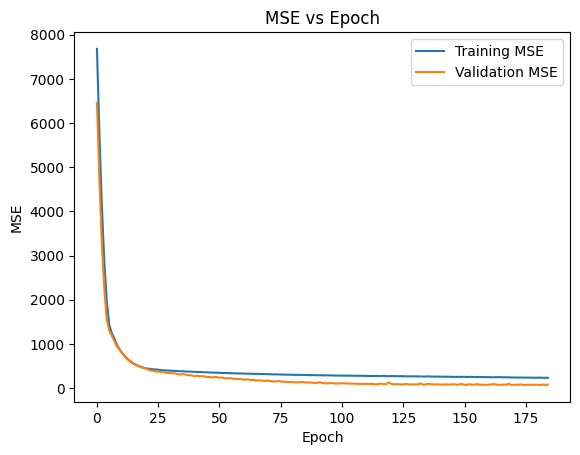

In [446]:
# Show MSE vs Epoch and save plot to file
plt.plot(train_mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs Epoch')
plt.savefig(os.path.join(ITERATION_FOLDER, "mse_vs_epoch.png"))
plt.show()


1/1 [==============================] - 0s 23ms/step - loss: 225.4190 - mae: 12.2212
MSE: 225.4189910888672
RMSE: 15.013959873693121
MAE: 12.221159934997559
1/1 [==============================] - 0s 22ms/step
(20, 4)


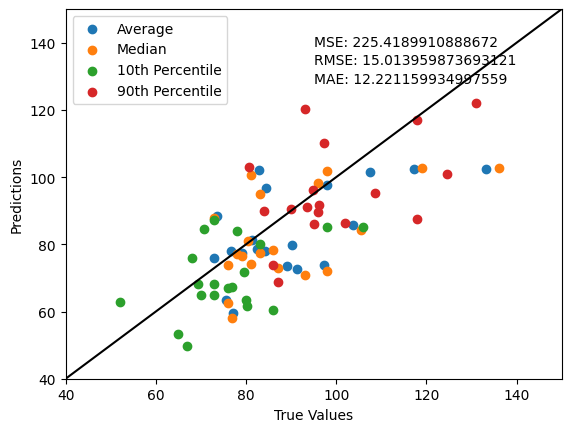

In [447]:
# Test model
TEST_EVALUATION = model.evaluate(X_test, y_test)
print("MSE:", TEST_EVALUATION[0])
print("RMSE:", np.sqrt(TEST_EVALUATION[0]))
print("MAE:", TEST_EVALUATION[1])

# scatter plot for all 4 individual values of the predictions
predictions = model.predict(X_test)

print(predictions.shape)

# Plot
plt.scatter(y_test[:, 0], predictions[:, 0], label="Average")
plt.scatter(y_test[:, 1], predictions[:, 1], label="Median")
plt.scatter(y_test[:, 2], predictions[:, 2], label="10th Percentile")
plt.scatter(y_test[:, 3], predictions[:, 3], label="90th Percentile")

plt.xlabel("True Values")
plt.ylabel("Predictions")

# # Plot x=y for reference
x = np.linspace(0, 200, 100)
y = x

plt.plot(x, y, color="black")

plt.xlim(40, 150)
plt.ylim(40, 150)

# Show MSE, RMSE, MAE
plt.annotate("MSE: {}".format(TEST_EVALUATION[0]), (0.5, 0.9), xycoords='axes fraction')
plt.annotate("RMSE: {}".format(np.sqrt(TEST_EVALUATION[0])), (0.5, 0.85), xycoords='axes fraction')
plt.annotate("MAE: {}".format(TEST_EVALUATION[1]), (0.5, 0.8), xycoords='axes fraction')

plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "scatter_plot.png"))
plt.show()

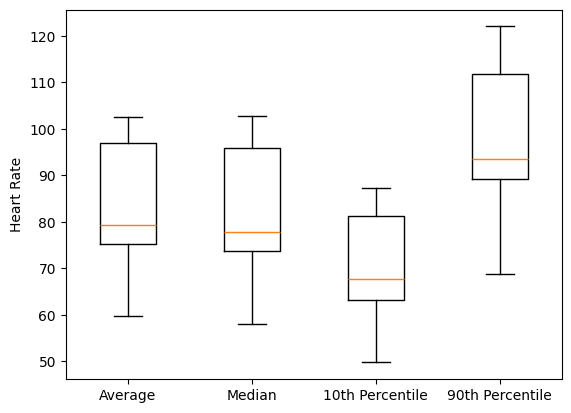

In [448]:
# Show whisker plot of the predictions
plt.boxplot(predictions)
plt.xticks([1, 2, 3, 4], ["Average", "Median", "10th Percentile", "90th Percentile"])
plt.ylabel("Heart Rate")
plt.savefig(os.path.join(ITERATION_FOLDER, "whisker_plot.png"))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


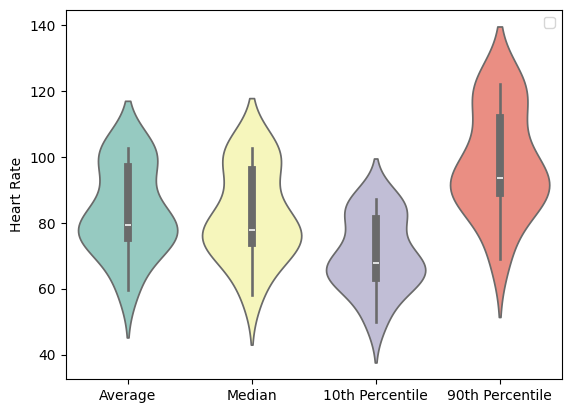

In [449]:
# Show violin plot of the predictions
sns.violinplot(predictions, palette="Set3")
plt.xticks([0, 1, 2, 3], ["Average", "Median", "10th Percentile", "90th Percentile"])
plt.ylabel("Heart Rate")
plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "violin_plot.png"))
plt.show()

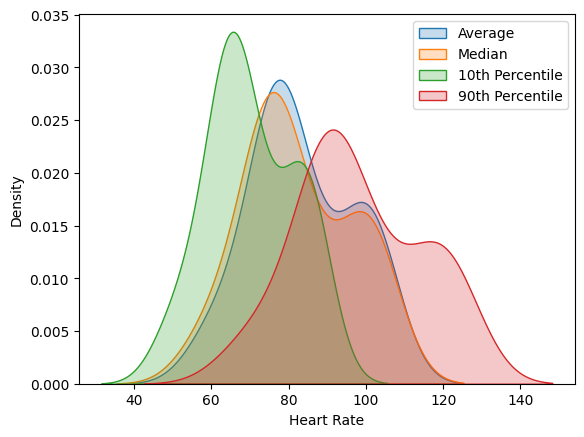

In [450]:
# Show density plot of the predictions and label the densities
sns.kdeplot(predictions[:, 0], fill=True, label="Average")
sns.kdeplot(predictions[:, 1], fill=True, label="Median")
sns.kdeplot(predictions[:, 2], fill=True, label="10th Percentile")
sns.kdeplot(predictions[:, 3], fill=True, label="90th Percentile")
plt.xlabel("Heart Rate")
plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "density_plot.png"))
plt.show()

## Save model to index file

In [451]:
# Make sure index file exists
INDEX_FILE_PATH = os.path.join(MODELS_FOLDER, "index.csv")
if not os.path.exists(INDEX_FILE_PATH):
    with open(INDEX_FILE_PATH, 'w') as f:
        f.write("INDEX, MODEL_NAME, LAYERS, RUN_EPOCHS, BATCH_SIZE, LEARNING_RATE, MSE, RMSE, MAE\n")

# Creates layer string like "32dense-64dense-128dense-10dense"
def get_layer_string(model):
    return "-".join([str(layer.units) + layer.name.split("_")[0] for layer in model.layers])

# Create method for creating short summary string
def get_model_summary(model, epochs, batch_size, lr):
    # Create layer string like "32dense-64dense-128dense-10dense"
    return "{}-e{}-b{}-lr{}".format(get_layer_string(model), epochs, batch_size, lr)

def get_csv_entry(model, epochs, batch_size, lr, mse, rmse, mae):
    return "{},{},{},{},{},{},{},{},{}\n".format(CURRENT_MODEL_ITERATION, model.name, get_layer_string(model), epochs, batch_size, lr, mse, rmse, mae)
    
# Save Entire model
MODEL_FILE_PATH = os.path.join(ITERATION_FOLDER, "model.keras")
model.save(MODEL_FILE_PATH)

# Save model config
MODEL_CONFIG_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_config.json")
with open(MODEL_CONFIG_FILE_PATH, 'w') as f:
    f.write(model.to_json())
    
# Append to index file
with open(INDEX_FILE_PATH, 'a') as f:
    f.write(get_csv_entry(model, RUN_EPOCHS, BATCH_SIZE, LEARNING_RATE, TEST_EVALUATION[0], np.sqrt(TEST_EVALUATION[0]), TEST_EVALUATION[1]))

## Testing model manually

In [452]:
# Print first sample
print (X_test[0])

# Volleybal
sample_vl = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 90, 1, 21, 5]

# Cooking
sample_c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1 ,0, 0, 0, 60, 1, 21, 5]

# Meeting
sample_m = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 30, 1, 21, 5]

sample_m_vl = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 60, 1, 8, 1]
sample_m_vl2 = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 60, 1, 21, 1]

# Predict
prediction = model.predict([sample_vl])
print(prediction)

prediction = model.predict([sample_c])
print(prediction)

prediction = model.predict([sample_m])
print(prediction)

prediction = model.predict([sample_m_vl])
print(prediction)
prediction = model.predict([sample_m_vl2])
print(prediction)

tf.Tensor([ 0  0  0  0  0  0  0  0  0  0  1  0  0 60  1 10  1], shape=(17,), dtype=int64)
1/1 [==============================] - 0s 67ms/step
[[101.18145 101.25469  83.92618 120.07555]]
1/1 [==============================] - 0s 38ms/step
[[100.34428  99.96131  84.63734 117.96555]]
1/1 [==============================] - 0s 38ms/step
[[102.71508  100.49647   88.699295 115.95142 ]]
1/1 [==============================] - 0s 39ms/step
[[63.11652  61.52319  53.521473 72.6138  ]]
1/1 [==============================] - 0s 37ms/step
[[102.31383 101.61646  85.6672  118.54586]]
